In [3]:
# module import
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # still experimental 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder  # scikit-learn과 호환됨
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import set_config
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import category_encoders as ce
import optuna
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution, UniformDistribution
from optuna.integration import OptunaSearchCV, ShapleyImportanceEvaluator
import re

### data load

In [4]:
train_df = pd.read_csv('train.csv').copy()
test_df = pd.read_csv('test.csv').copy()
park_df = pd.read_csv('park.csv').copy()
submission_df = pd.read_csv('submission.csv').copy()
day_care_center_df = pd.read_csv('day_care_center.csv').copy()

In [5]:
train_df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,657299,2753,부산광역시,서대신동3가,409,대윤스위트,서대신동3가 409 대윤스위트,112.24,2001,201309,11~20,5,23500
1,796707,2631,부산광역시,대연동,245,대우그린1,대연동 245 대우그린1,59.99,1997,201610,21~31,7,17000
2,656264,6106,부산광역시,서대신동2가,414-1,새부산,서대신동2가 414-1 새부산,60.26,1976,201112,11~20,5,7500
3,539545,11710,서울특별시,논현동,105-4,한진로즈힐,논현동 105-4 한진로즈힐,84.94,2004,201105,21~31,8,62500
4,188009,9460,서울특별시,하계동,273,장미(시영6),하계동 273 장미(시영6),54.29,1989,200909,11~20,9,24600


In [6]:
test_df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1500000,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3
1,1500001,12536,서울특별시,인의동,48-2,효성쥬얼리시티,인의동 48-2 효성쥬얼리시티,92.81,2006,200801,1~10,7
2,1500002,12536,서울특별시,인의동,48-2,효성쥬얼리시티,인의동 48-2 효성쥬얼리시티,84.98,2006,200801,21~31,7
3,1500003,7808,서울특별시,명륜1가,45-5,아마레스,명륜1가 45-5 아마레스,84.59,2002,200801,1~10,1
4,1500004,7756,서울특별시,명륜2가,237,아남3,명륜2가 237 아남3,50.49,1999,200801,21~31,4


In [7]:
park_df

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,NaN,NaN,NaN,NaN,NaN,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,NaN,NaN,NaN,NaN,NaN,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,NaN,NaN,NaN,NaN,NaN,1970.0,2018-08-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,서울특별시,구로구,천왕동,이펜시아어린이공원,어린이공원,1500.0,NaN,조합놀이 1기,NaN,NaN,NaN,2006.0,2019-02-25
1355,서울특별시,구로구,천왕동,개명소공원,소공원,5415.0,NaN,NaN,NaN,NaN,NaN,2006.0,2019-02-25
1356,서울특별시,구로구,천왕동,봉화대근린공원,근린공원,60975.0,NaN,NaN,NaN,NaN,NaN,2006.0,2019-02-25
1357,서울특별시,구로구,항동,푸른수목원,근린공원,100809.0,NaN,NaN,NaN,NaN,NaN,2005.0,2019-02-25


In [8]:
day_care_center_df

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle,reference_date
0,서울특별시,서대문구,가람어린이집,국공립,70,11.0,5.0,1.0,7.0,N,2018-07-31
1,서울특별시,서대문구,가좌제일어린이집,국공립,88,22.0,5.0,2.0,10.0,N,2018-07-31
2,서울특별시,서대문구,경찰청어린이집,직장,90,23.0,6.0,1.0,32.0,N,2018-07-31
3,서울특별시,서대문구,고운햇살어린이집,가정,18,5.0,3.0,0.0,4.0,N,2018-07-31
4,서울특별시,서대문구,고은어린이집,국공립,93,20.0,7.0,2.0,10.0,N,2018-07-31
...,...,...,...,...,...,...,...,...,...,...,...
7546,부산광역시,금정구,해바라기어린이집,민간,46,13.0,NaN,NaN,NaN,y,2019-01-21
7547,부산광역시,금정구,해수어린이집,가정,19,6.0,NaN,NaN,NaN,y,2019-01-21
7548,부산광역시,금정구,행복한그림동산어린이집,민간,92,16.0,NaN,NaN,NaN,y,2019-01-21
7549,부산광역시,금정구,행복한어린이집,민간,43,12.0,NaN,NaN,NaN,y,2019-01-21


### data preprocessing

In [9]:
# 숫자 나오기 전까지 동 자르기, 같은 읍끼리 통합, 같은 면끼리 통합 -> (깔끔하게 ~동 ~읍 ~면으로만 구분되게 뒤에 도로명 통합)
def get_substring_before_number(input_string):
    result = ""
    for char in input_string:
        if char.isdigit():
            break
        result += char
    return result

def get_substring_before_space(input_string):
    result = ""
    for char in input_string:
        if char == " ":
            break
        result += char
    return result

train_df['dong'] = train_df['dong'].map(lambda x : get_substring_before_number(x))
test_df['dong'] = test_df['dong'].map(lambda x : get_substring_before_number(x))

In [10]:
# 공공데이터포털 서울 자치구별 지하철역 정보, 부산교통공사 지하철 정보
# 구 이용해서 park에 지하철역 개수 합쳐놓기
seoul_metro_df =pd.read_csv('서울 자치구별 지하철역.csv', encoding='cp949').copy()
seoul_metro_df = seoul_metro_df.loc[0:24]
seoul_metro_df = seoul_metro_df[['자치구','역개수']]
busan_metro_df=pd.read_csv('학회_부산메트로_주소.csv').copy()

seoul_metro_df.rename(columns = {'자치구':'gu'}, inplace=True)


busan_metro_df['city'] = busan_metro_df['지번주소'].apply(lambda x: x.split()[0])
busan_metro_df['gu'] = busan_metro_df['지번주소'].apply(lambda x: x.split()[1])
busan_metro_df['dong'] = busan_metro_df['지번주소'].apply(lambda x: x.split()[2])
busan_metro_df['dong'] = busan_metro_df['dong'].map(lambda x : get_substring_before_number(x))
busan_metro_df.drop(['철도운영기관명','도로명주소','지번주소'], axis = 1, inplace=True)
busan_metro_df = busan_metro_df.groupby('gu')['역명'].agg('count').reset_index()
busan_metro_df.rename(columns = {'역명':'역개수'}, inplace=True)

seoul_metro_df
busan_metro_df

,gu,역개수
0,강서구,3
1,금정구,9
2,기장군,2
3,남구,6
4,동구,5
5,동래구,11
6,부산진구,10
7,북구,13
8,사상구,7
9,사하구,12


In [11]:
# 서울, 부산 이름 겹치는 구 있어서 서울,부산 우선 분리후 인덱스 기준 다시 붙이기
a = park_df[park_df['city'] == '서울특별시']
b = park_df[park_df['city'] == '부산광역시']

a = pd.merge(a, seoul_metro_df, on ='gu', how = 'left')
b = pd.merge(b, busan_metro_df, on ='gu', how = 'left')

park_df = pd.concat([a,b]).sort_index()

In [12]:
# train,test 각각에 역 개수 feature 생성
station_count = park_df.groupby('dong')['역개수'].mean().reset_index()
train_df['station_num'] = train_df['dong'].map(station_count.set_index('dong')['역개수']).fillna(0)
test_df['station_num'] = test_df['dong'].map(station_count.set_index('dong')['역개수']).fillna(0)

In [13]:
# 구별 보육원 개수
daycare_counts_dict = day_care_center_df['gu'].value_counts().to_dict()
park_df['day_care_num'] = park_df['gu'].map(daycare_counts_dict).fillna(0).astype(int)

# 구별 보육원 다니는 아이 합
baby_sum_df = day_care_center_df.groupby('gu')['day_care_baby_num'].sum().reset_index()
park_df['baby_sum'] = park_df['gu'].map(baby_sum_df.set_index('gu')['day_care_baby_num']).fillna(0)

# 동별 공원 수
park_counts_dict = park_df['dong'].value_counts().to_dict()
train_df['park_num'] = train_df['dong'].map(park_counts_dict).fillna(0).astype(int)
test_df['park_num'] = test_df['dong'].map(park_counts_dict).fillna(0).astype(int)

# 동별 공원 면적 합
area_sum_df = park_df.groupby('dong')['park_area'].sum().reset_index()
train_df['park_sum'] = train_df['dong'].map(area_sum_df.set_index('dong')['park_area']).fillna(0)
test_df['park_sum'] = test_df['dong'].map(area_sum_df.set_index('dong')['park_area']).fillna(0)

# 동별 보육원 개수 
dong_day_care_count = park_df.groupby('dong')['day_care_num'].mean().reset_index()
train_df['day_care'] = train_df['dong'].map(dong_day_care_count.set_index('dong')['day_care_num']).fillna(park_df['day_care_num'].mean()).astype(int)
test_df['day_care'] = test_df['dong'].map(dong_day_care_count.set_index('dong')['day_care_num']).fillna(park_df['day_care_num'].mean()).astype(int)

# 동별 보육원 다니는 아이 합
dong_baby_count = park_df.groupby('dong')['baby_sum'].mean().reset_index()
train_df['baby'] = train_df['dong'].map(dong_baby_count.set_index('dong')['baby_sum']).fillna(park_df['baby_sum'].mean()).astype(int)
test_df['baby'] = test_df['dong'].map(dong_baby_count.set_index('dong')['baby_sum']).fillna(park_df['baby_sum'].mean()).astype(int)

In [14]:
# train, test 결측치비율 확인
print('train_df 결측치 비율 \n')

for col in train_df.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * train_df[col].isnull().sum() / train_df[col].shape[0])
    print(msg)

print('\n')

print('test_df 결측치 비율 \n')

for col in test_df.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * test_df[col].isnull().sum() / test_df[col].shape[0])
    print(msg)

train_df 결측치 비율 

column: transaction_id	 Percent of NaN value: 0.00%
column: apartment_id	 Percent of NaN value: 0.00%
column:       city	 Percent of NaN value: 0.00%
column:       dong	 Percent of NaN value: 0.00%
column:      jibun	 Percent of NaN value: 0.00%
column:        apt	 Percent of NaN value: 0.00%
column:    addr_kr	 Percent of NaN value: 0.00%
column: exclusive_use_area	 Percent of NaN value: 0.00%
column: year_of_completion	 Percent of NaN value: 0.00%
column: transaction_year_month	 Percent of NaN value: 0.00%
column: transaction_date	 Percent of NaN value: 0.00%
column:      floor	 Percent of NaN value: 0.00%
column: transaction_real_price	 Percent of NaN value: 0.00%
column: station_num	 Percent of NaN value: 0.00%
column:   park_num	 Percent of NaN value: 0.00%
column:   park_sum	 Percent of NaN value: 0.00%
column:   day_care	 Percent of NaN value: 0.00%
column:       baby	 Percent of NaN value: 0.00%


test_df 결측치 비율 

column: transaction_id	 Percent of NaN value: 

In [ ]:
# train, test 총 거래년 범위 확인
unique_train_years = set(train_df['year'].unique())
unique_test_years = set(test_df['year'].unique())
unique_years = unique_train_years.union(unique_test_years)
unique_years

In [15]:
# 한국은행 기준금리 데이터 발췌
year_month = ['200808', '200810', '200811', '200812', '200901','200902', '201007', '201011', '201101', '201103', '201106', '201207', '201210',
       '201305', '201408','201410', '201503', '201506' , '201606', '201711', '201811']
rate = [5.25, 4.25, 4, 3, 2.5, 2, 2.25, 2.5, 2.75, 3, 3.25, 3, 2.75, 2.5, 2.25, 2, 1.75, 1.5, 1.25, 1.5, 1.75 ]

house_rate = pd.DataFrame({'year_month': year_month, 'rate': rate})
house_rate['year_month'] = house_rate['year_month'].astype(int)
house_rate

def rate(x):
    if x < 200808:
        return 5.25
    else : 
        for i in house_rate['year_month'].index:
            if house_rate.loc[i,"year_month"] <= x < house_rate.loc[i+1,"year_month"]:
                return house_rate.loc[i,"rate"]

train_df['loan_rate'] = train_df['transaction_year_month'].map(lambda x : rate(x))
test_df['loan_rate'] = test_df['transaction_year_month'].map(lambda x : rate(x))



In [16]:
# 거래 연,월 구분
train_df['year'] = train_df['transaction_year_month'] // 100
train_df['month'] = train_df['transaction_year_month'] % 100

test_df['year'] = test_df['transaction_year_month'] // 100
test_df['month'] = test_df['transaction_year_month'] % 100


train_df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,...,floor,transaction_real_price,station_num,park_num,park_sum,day_care,baby,loan_rate,year,month
0,657299,2753,부산광역시,서대신동,409,대윤스위트,서대신동3가 409 대윤스위트,112.24,2001,201309,...,5,23500,0.0,0,0.0,296,13047,2.50,2013,9
1,796707,2631,부산광역시,대연동,245,대우그린1,대연동 245 대우그린1,59.99,1997,201610,...,7,17000,6.0,15,411583.1,143,6676,1.25,2016,10
2,656264,6106,부산광역시,서대신동,414-1,새부산,서대신동2가 414-1 새부산,60.26,1976,201112,...,5,7500,0.0,0,0.0,296,13047,3.25,2011,12
3,539545,11710,서울특별시,논현동,105-4,한진로즈힐,논현동 105-4 한진로즈힐,84.94,2004,201105,...,8,62500,21.0,9,40555.2,223,11605,3.00,2011,5
4,188009,9460,서울특별시,하계동,273,장미(시영6),하계동 273 장미(시영6),54.29,1989,200909,...,9,24600,0.0,0,0.0,296,13047,2.00,2009,9


In [18]:
# 전용면적 10 단위로 그룹화
train_df['area_group'] = train_df.exclusive_use_area.map(lambda x: str(x)[0] if x < 100 else str(x)[:2])
test_df['area_group'] = test_df.exclusive_use_area.map(lambda x: str(x)[0] if x < 100 else str(x)[:2])

# 평수로 변환
train_df['3.3m2'] = train_df.exclusive_use_area / 3.3
test_df['3.3m2'] = test_df.exclusive_use_area / 3.3                                                       

#평수 10평 단위로 그룹화
train_df['3.3m2_group'] = train_df['3.3m2'].map(lambda x: str(x)[:2] if x >= 100 else (str(x)[0] if x >= 10 else '0'))
test_df['3.3m2_group'] = test_df['3.3m2'].map(lambda x: str(x)[:2] if x >= 100 else (str(x)[0] if x >= 10 else '0'))

In [19]:
# 새로만든 구간값 수치화
train_df['area_group'] = train_df['area_group'].astype(int)
test_df['area_group'] = test_df['area_group'].astype(int)
train_df['3.3m2_group'] = train_df['3.3m2_group'].astype(int)
test_df['3.3m2_group'] = test_df['3.3m2_group'].astype(int)

In [20]:
# 다른동, 이름 겹치는 apt 방지 -> apt랑 dong 합치기 (고유화 작업)
train_df['apt'] = train_df['dong'] + train_df['apt']
test_df['apt'] = test_df['dong']  + test_df['apt']
train_df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,...,park_num,park_sum,day_care,baby,loan_rate,year,month,area_group,3.3m2,3.3m2_group
0,657299,2753,부산광역시,서대신동,409,서대신동대윤스위트,서대신동3가 409 대윤스위트,112.24,2001,201309,...,0,0.0,296,13047,2.50,2013,9,11,34.012121,3
1,796707,2631,부산광역시,대연동,245,대연동대우그린1,대연동 245 대우그린1,59.99,1997,201610,...,15,411583.1,143,6676,1.25,2016,10,5,18.178788,1
2,656264,6106,부산광역시,서대신동,414-1,서대신동새부산,서대신동2가 414-1 새부산,60.26,1976,201112,...,0,0.0,296,13047,3.25,2011,12,6,18.260606,1
3,539545,11710,서울특별시,논현동,105-4,논현동한진로즈힐,논현동 105-4 한진로즈힐,84.94,2004,201105,...,9,40555.2,223,11605,3.00,2011,5,8,25.739394,2
4,188009,9460,서울특별시,하계동,273,하계동장미(시영6),하계동 273 장미(시영6),54.29,1989,200909,...,0,0.0,296,13047,2.00,2009,9,5,16.451515,1


In [21]:
# 아파트 연식 feature 추가(거래년 기준 - 완공연도)
train_df['apt_age'] = train_df['year'] - train_df['year_of_completion']
test_df['apt_age'] = test_df['year'] - test_df['year_of_completion']

In [22]:
# 거래일 월초/월중순/월말 구분해서 0/1/2 라벨 인코딩
train_df['transaction_date'] = train_df['transaction_date'].replace({'1~10' : 0, '11~20': 1, '21~31' : 2, '21~30' : 2, '21~29' : 2, '21~28' : 2 })
test_df['transaction_date'] = test_df['transaction_date'].replace({'1~10' : 0, '11~20': 1, '21~31' : 2, '21~30' : 2, '21~29' : 2, '21~28' : 2  })
train_df['transaction_date'] = train_df['transaction_date'].astype(int)
test_df['transaction_date'] = test_df['transaction_date'].astype(int)

In [23]:
# 층별 데이터 count 피쳐 생성
floor_tr = train_df.groupby('floor')['transaction_id'].agg('count').reset_index()
floor_te = test_df.groupby('floor')['transaction_id'].agg('count').reset_index()
train_df = pd.merge(train_df, floor_tr, on='floor', how = 'left')
test_df = pd.merge(test_df, floor_te, on='floor', how = 'left')



In [24]:
# 이름 중복된 컬럼 원상복구
train_df = train_df.rename(columns = {'transaction_id_x' : 'transaction_id','transaction_id_y' : 'floor_c'})
test_df = test_df.rename(columns = {'transaction_id_x' : 'transaction_id','transaction_id_y' : 'floor_c'})

In [25]:
#층과 평수를 곱함 - 넓은 집의 경우 낮은 층이여도 높은 숫자로 표현
train_df['floor_area']=train_df['floor']*train_df['year']
test_df['floor_area']=test_df['floor']*test_df['year']

#층과 년도를 곱합- 예전 집일수록 저층의 건물이 낮은 수치로 나옴
train_df['floor_year']=train_df['floor']*train_df['3.3m2']
test_df['floor_year']=test_df['floor']*test_df['3.3m2']

In [26]:
#apartment id의 길이
train_df['id_len'] = train_df['apartment_id'].map(lambda x : len(str(x)))
test_df['id_len'] = test_df['apartment_id'].map(lambda x : len(str(x)))

In [27]:
# 거래월 기준 계절분리
def season(x):
    if x in [1,2,11,12]:
        return 4
    elif x in [3,4,5]:
        return 1
    elif x in [6,7,8]:
        return 2
    elif x in [9,10]:
        return 3

train_df['season'] = train_df['month'].map(lambda x : season(x))
test_df['season'] = test_df['month'].map(lambda x : season(x))

In [28]:
# 층별 면적 평균
train_usearea = train_df.groupby('floor')['exclusive_use_area'].agg('mean').reset_index().sort_values(by = 'exclusive_use_area',ascending=False)
test_usearea = test_df.groupby('floor')['exclusive_use_area'].agg('mean').reset_index().sort_values(by = 'exclusive_use_area',ascending=False)
train_usearea.rename(columns = {'exclusive_use_area':'floor_areamean'}, inplace=True)
test_usearea.rename(columns = {'exclusive_use_area':'floor_areamean'}, inplace=True)

train_df = pd.merge(train_df, train_usearea, on ='floor', how ='left')
test_df = pd.merge(test_df, test_usearea, on ='floor', how ='left')

In [29]:
# 주요 시공사 구분하여 범주화, 10개안에 들지 않는 apt는 other로 구분
# brands = ['래미안', '힐스테이트', '자이', '더샵', '이편한세상', '푸르지오', '롯데캐슬', '아이파크', '포레나', '위브', '아크로', 'other']
company_name_tr = []
company_name_te = []
for i in train_df['apt']:
    if '래미안' in i :
        company_name_tr.append('래미안')
    elif '힐스테이트' in i:
        company_name_tr.append('힐스테이트')
    elif '자이' in i:
        company_name_tr.append('자이')
    elif '샵' in i or '더샵' in i:
        company_name_tr.append('더샵')
    elif '편한' in i:
        company_name_tr.append('이편한세상')
    elif '푸르지오' in i :
        company_name_tr.append('푸르지오')
    elif '롯데캐슬' in i:
        company_name_tr.append('롯데캐슬')
    elif '아이파크' in i or 'i파크' in i or 'ipark' in i or 'I파크' in i or 'Ipark' in i:
        company_name_tr.append('아이파크')
    elif '포레나' in i:
        company_name_tr.append('포레나')
    elif '위브' in i:
        company_name_tr.append('위브')
    elif '아크로' in i:
        company_name_tr.append('아크로')
    else:
        company_name_tr.append('other')

for i in test_df['apt']:
    if '래미안' in i :
        company_name_te.append('래미안')
    elif '힐스테이트' in i:
        company_name_te.append('힐스테이트')
    elif '자이' in i:
        company_name_te.append('자이')
    elif '샵' in i or '샾' in i:
        company_name_te.append('더샵')
    elif '편한' in i:
        company_name_te.append('이편한세상')
    elif '푸르지오' in i :
        company_name_te.append('푸르지오')
    elif '롯데캐슬' in i:
        company_name_te.append('롯데캐슬')
    elif '아이파크' in i or 'i파크' in i or 'ipark' in i or 'I파크' in i or 'Ipark' in i:
        company_name_te.append('아이파크')
    elif '포레나' in i:
        company_name_te.append('포레나')
    elif '위브' in i:
        company_name_te.append('위브')
    elif '아크로' in i:
        company_name_te.append('아크로')
    else:
        company_name_te.append('other')

train_df['company'] = company_name_tr
test_df['company'] = company_name_te



In [30]:
# 아파트 범주 개수
train_df.company.value_counts()

company
other    747483
래미안       25793
롯데캐슬      17304
푸르지오      13206
이편한세상     10929
힐스테이트      8918
자이         8160
위브         7751
아이파크       6031
더샵         4834
아크로        1178
Name: count, dtype: int64

In [31]:
# 브랜드별 층수의 평균(고층 비율 나타낼수 있지 않을까)
floor_mean_tr = train_df.groupby('company')['floor'].agg('mean').reset_index()
floor_mean_te = test_df.groupby('company')['floor'].agg('mean').reset_index()

train_df = pd.merge(train_df, floor_mean_tr, on='company', how = 'left')
test_df = pd.merge(test_df, floor_mean_te, on='company', how = 'left')
train_df = train_df.rename(columns = {'floor_x' : 'floor','floor_y' : 'brand_floor'})
test_df = test_df.rename(columns = {'floor_x' : 'floor','floor_y' : 'brand_floor'})

In [33]:
# feature set type 구분
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851587 entries, 0 to 851586
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   transaction_id          851587 non-null  int64  
 1   apartment_id            851587 non-null  int64  
 2   city                    851587 non-null  object 
 3   dong                    851587 non-null  object 
 4   jibun                   851587 non-null  object 
 5   apt                     851587 non-null  object 
 6   addr_kr                 851587 non-null  object 
 7   exclusive_use_area      851587 non-null  float64
 8   year_of_completion      851587 non-null  int64  
 9   transaction_year_month  851587 non-null  int64  
 10  transaction_date        851587 non-null  int64  
 11  floor                   851587 non-null  int64  
 12  transaction_real_price  851587 non-null  int64  
 13  station_num             851587 non-null  float64
 14  park_num            

### 범주형 변수 인코딩, 수치형 변수 스케일링

In [34]:
# 필요없는 열 삭제
X_train = train_df.drop(columns = ['transaction_id','jibun','addr_kr','transaction_year_month'])
X_test = test_df.drop(columns = ['transaction_id','jibun','addr_kr','transaction_year_month'])

In [35]:
# city feature (이진변수로 부산 0, 서울 1로 대체)
X_train['city'] = X_train['city'].replace({'부산광역시': 0, '서울특별시': 1})
X_test['city'] = X_test['city'].replace({'부산광역시': 0, '서울특별시': 1})

## idea : 서울/부산의 집값 스케일이 다르니 데이터 구분해서 개별 모델로 학습

In [36]:
# Seoul, Busan으로 데이터 나누기
X_trainB = X_train[X_train['city'] == 0]
X_trainS =  X_train[X_train['city'] == 1]
X_testB = X_test[X_test['city'] == 0]
X_testS = X_test[X_test['city'] == 1]

In [37]:
# 부산 dong,apt,company 범주형 변수 -> label encoding 클래스 객체에 추가
label_encoder = LabelEncoder()
X_trainB['dong'] = label_encoder.fit_transform(X_trainB['dong'])

for label in np.unique(X_testB['dong']):
    if label not in label_encoder.classes_:
        label_encoder.classes_ = np.append(label_encoder.classes_,label)
X_testB['dong'] = label_encoder.fit_transform(X_testB['dong'])

X_trainB['apt'] = label_encoder.fit_transform(X_trainB['apt'])

for label in np.unique(X_testB['apt']):
    if label not in label_encoder.classes_:
        label_encoder.classes_ = np.append(label_encoder.classes_,label)
X_testB['apt'] = label_encoder.fit_transform(X_testB['apt'])

X_trainB['company'] = label_encoder.fit_transform(X_trainB['company'])

for label in np.unique(X_testB['company']):
    if label not in label_encoder.classes_:
        label_encoder.classes_ = np.append(label_encoder.classes_,label)
X_testB['company'] = label_encoder.fit_transform(X_testB['company'])

In [38]:
# 서울 dong,apt,company 범주형 변수 -> label encoding 클래스 객체에 추가
label_encoder = LabelEncoder()
X_trainS['dong'] = label_encoder.fit_transform(X_trainS['dong'])

for label in np.unique(X_testS['dong']):
    if label not in label_encoder.classes_:
        label_encoder.classes_ = np.append(label_encoder.classes_,label)
X_testS['dong'] = label_encoder.fit_transform(X_testS['dong'])

X_trainS['apt'] = label_encoder.fit_transform(X_trainS['apt'])

for label in np.unique(X_testS['apt']):
    if label not in label_encoder.classes_:
        label_encoder.classes_ = np.append(label_encoder.classes_,label)
X_testS['apt'] = label_encoder.fit_transform(X_testS['apt'])

X_trainS['company'] = label_encoder.fit_transform(X_trainS['company'])

for label in np.unique(X_testS['company']):
    if label not in label_encoder.classes_:
        label_encoder.classes_ = np.append(label_encoder.classes_,label)
X_testS['company'] = label_encoder.fit_transform(X_testS['company'])

In [39]:
# 컬럼수 확인(29)
X_trainB

,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,station_num,...,3.3m2_group,apt_age,floor_c,floor_area,floor_year,id_len,season,floor_areamean,company,brand_floor
0,2753,0,65,2364,112.2400,2001,1,5,23500,0.0,...,3,12,62256,10065,170.060606,4,3,75.037665,0,9.013897
1,2631,0,31,1323,59.9900,1997,2,7,17000,6.0,...,1,19,48979,14112,127.251515,4,3,77.718823,0,9.013897
2,6106,0,65,2380,60.2600,1976,1,5,7500,0.0,...,1,35,62256,10055,91.303030,4,4,75.037665,0,9.013897
7,6226,0,53,1999,23.8800,2004,0,19,5700,0.0,...,0,9,15046,38247,137.490909,4,4,80.987975,0,9.013897
11,12260,0,91,3440,84.9985,2007,2,1,17508,0.0,...,2,1,52409,2008,25.757121,5,4,76.270158,0,9.013897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851574,12029,0,20,931,84.6900,1994,2,7,16400,0.0,...,2,20,48979,14098,179.645455,5,4,77.718823,0,9.013897
851575,6197,0,66,2450,59.8700,2003,0,14,9444,9.0,...,1,8,34287,28154,253.993939,4,3,77.297033,0,9.013897
851579,9825,0,80,2908,75.7500,1986,0,15,26000,8.0,...,2,29,31895,30225,344.318182,4,1,77.187105,0,9.013897
851581,4981,0,104,3751,60.4800,1993,2,8,12500,7.0,...,1,20,46685,16104,146.618182,4,3,77.366604,0,9.013897


In [40]:
# 나머지 수치형 변수 MinMaxScaler 활용하여 scale 맞춰주기
columns_to_scale = ['exclusive_use_area', 'year_of_completion','park_num', 'year', 'month', '3.3m2', 'floor', 'floor_c', 'floor_area', 'floor_year', 'floor_areamean']
scaler = MinMaxScaler()
X_trainB[columns_to_scale] = scaler.fit_transform(X_trainB[columns_to_scale])
X_testB[columns_to_scale] = scaler.transform(X_testB[columns_to_scale])
X_trainS[columns_to_scale] = scaler.fit_transform(X_trainS[columns_to_scale])
X_testS[columns_to_scale] = scaler.transform(X_testS[columns_to_scale])

## Feature selection

<Axes: >

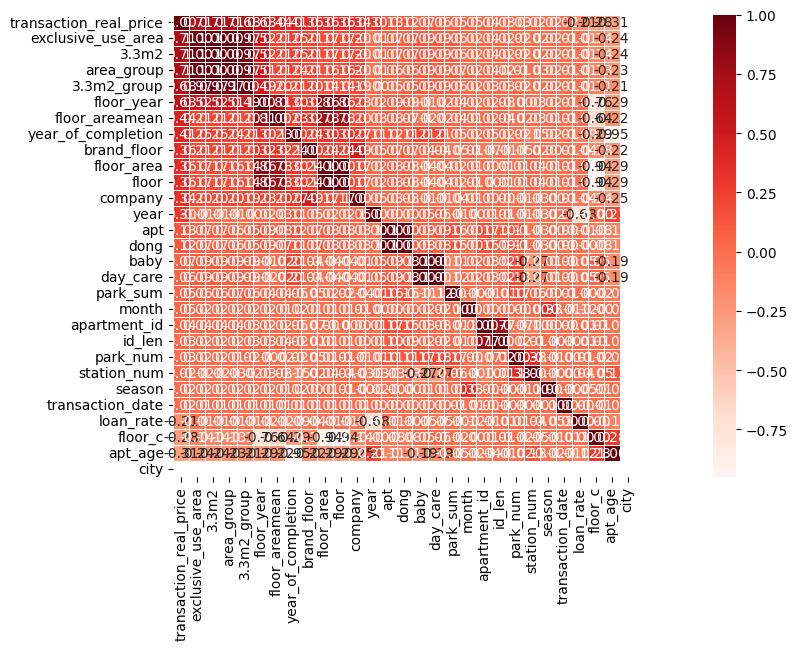

In [41]:
# 부산 Target과의 상관관계 분석
k=X_trainB.shape[1] #히트맵 변수 갯수
corrmat = X_trainB.corr() #변수간의 상관관계
cols = corrmat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index #price기준으로 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(X_trainB[cols].values.T)
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

In [43]:
# Busan, Seoul 실제 train/target값으로 분리(상관성 겹치는 변수 중복 학습 feature 삭제)
y_trainB = X_trainB['transaction_real_price']
y_trainS = X_trainS['transaction_real_price']

X_trainB = X_trainB.drop(columns = ['transaction_real_price','3.3m2','floor_area','apt'])
X_trainS = X_trainS.drop(columns = ['transaction_real_price','3.3m2','floor_area','apt'])
X_testB = X_testB.drop(columns = ['3.3m2','floor_area','apt'])
X_testS = X_testS.drop(columns = ['3.3m2','floor_area','apt'])


In [44]:
# feature importance 확인
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances


Model Tune for Cat.


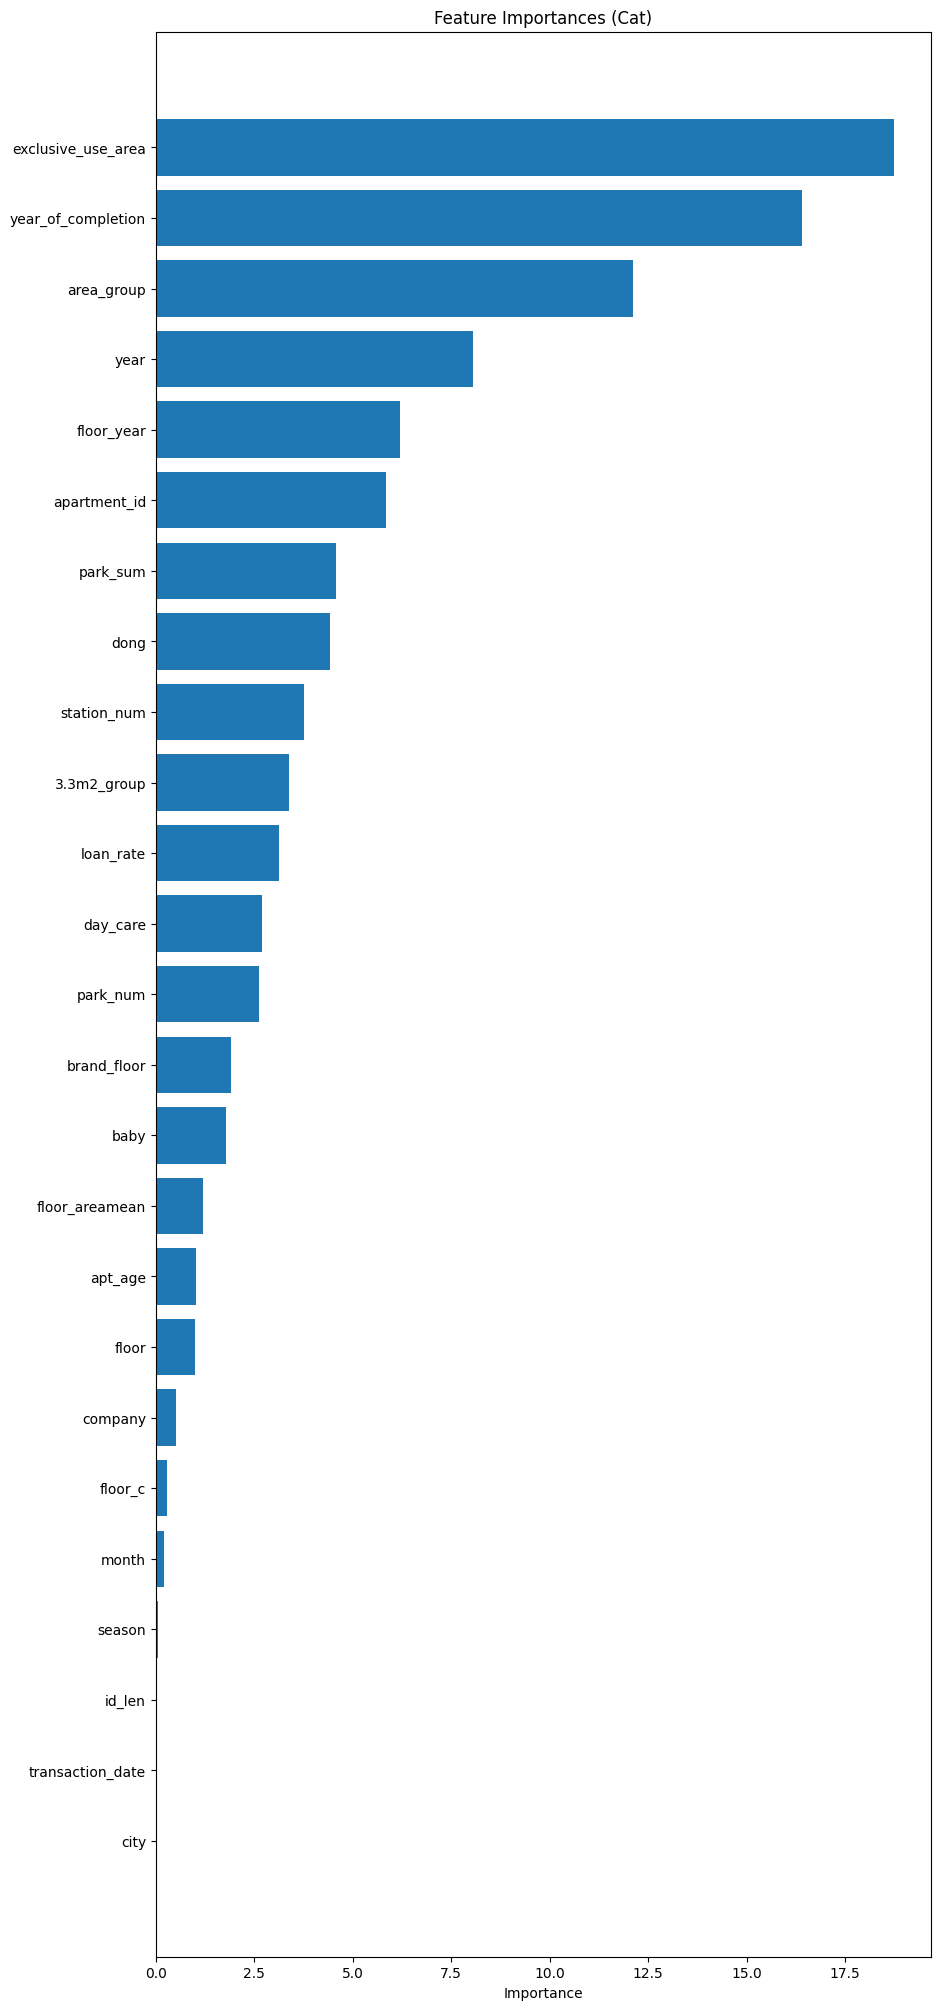

Model Tune for Cat.


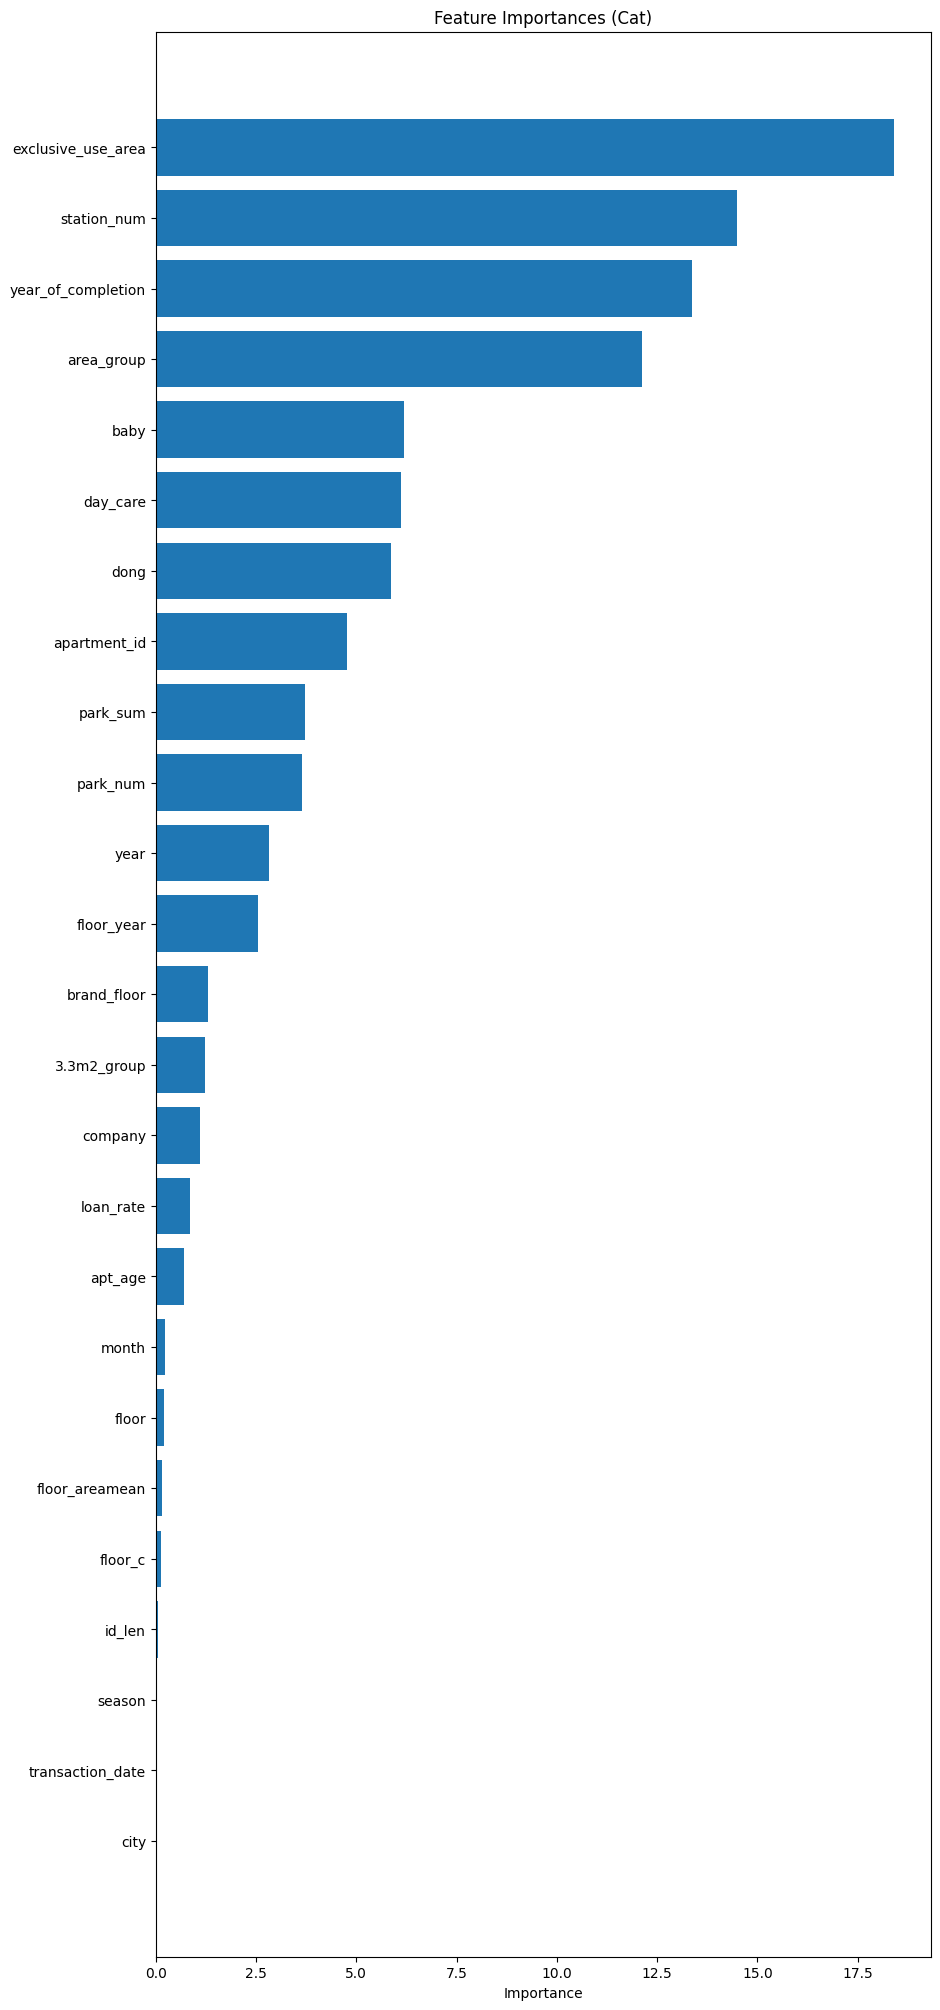

In [45]:
from catboost import CatBoostRegressor

# CatBoostRegressor에 맞는 feature selection
cat_modelB, cat_featureB_importances = train_and_evaluate(CatBoostRegressor(verbose=False), 'Cat', X_trainB, y_trainB)
cat_modelS, cat_featureS_importances = train_and_evaluate(CatBoostRegressor(verbose=False), 'Cat', X_trainS, y_trainS)

In [46]:
# 임계치 threshold 0.1로 설정후 학습,target set 생성
low_importance_featuresB = X_trainB.columns[cat_featureB_importances < 0.1]
low_importance_featuresS = X_trainS.columns[cat_featureS_importances < 0.1]

X_trainB = X_trainB.drop(columns=low_importance_featuresB)
X_trainS = X_trainS.drop(columns=low_importance_featuresS)
X_testB = X_testB.drop(columns=low_importance_featuresB)
X_testS = X_testS.drop(columns=low_importance_featuresS)


In [48]:
# 시간적 한계로 과거 전체 feature 활용하여 개별 모델 optuna 했을때의 best parameter 고정적으로 활용 (컴페티션 이재원 최종 2차.ipynb 참고 첨부)
# 부산
best_modelA = CatBoostRegressor(
    verbose=False,
    depth = 11,
    min_child_samples = 153,
    learning_rate = 0.19988826038559168,
    n_estimators = 698,
    random_state = 80)

best_modelA.fit(X_trainB, y_trainB)

In [49]:
# 시간적 한계로 과거 전체 feature 활용하여 개별 모델 optuna 했을때의 best parameter 고정적으로 활용 (컴페티션 이재원 최종 2차.ipynb 참고 첨부)
# 서울
best_modelB = CatBoostRegressor(
    verbose=False,
    depth = 13,
    min_child_samples = 42,
    learning_rate =  0.15068383793116955,
    n_estimators = 505,
    random_state = 80)

best_modelB.fit(X_trainS, y_trainS)

In [50]:
# 과적합 감소 위해 oof 활용해 교차검증 후 예측값 생성(부산)
from sklearn.model_selection import cross_validate
modelsA = cross_validate(best_modelA, 
                        X_trainB, y_trainB, cv=9, scoring='neg_mean_squared_error', 
                        return_estimator=True)
oof_predA = np.array([m.predict(X_testB) for m in modelsA['estimator']]).mean(axis=0)

scores = modelsA['test_score']
print("\nTuned LM CV scores: ", np.sqrt(-1*scores))
print("Tuned LM CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))



Tuned LM CV scores:  [2174.31309602 2135.13631143 2103.01468502 1995.79845782 1969.52213555
 2322.56872199 2213.64697562 2002.5097372  1997.98585441]
Tuned LM CV mean = 2104.70 with std = 697.30


In [51]:
# 과적합 감소 위해 oof 활용해 교차검증 후 예측값 생성(서울)
from sklearn.model_selection import cross_validate
modelsB = cross_validate(best_modelB, 
                        X_trainS, y_trainS, cv=9, scoring='neg_mean_squared_error', 
                        return_estimator=True)
oof_predB = np.array([m.predict(X_testS) for m in modelsB['estimator']]).mean(axis=0)

scores = modelsB['test_score']
print("\nTuned LM CV scores: ", np.sqrt(-1*scores))
print("Tuned LM CV mean = %.2f" % np.sqrt(-1*scores.mean()), "with std = %.2f" % np.sqrt(scores.std()))


Tuned LM CV scores:  [5073.95911072 4849.38913143 5022.81582303 5094.06519825 5009.35810098
 5404.78925295 4963.63887747 5080.46725172 5255.56020677]
Tuned LM CV mean = 5086.09 with std = 1255.04


In [52]:
# 예측값 X_test에 임시로 붙임
X_testB['pred'] = oof_predA
X_testS['pred'] = oof_predB

In [53]:
# 위아래 그대로 concat후 다시 원 인덱스 기준 정렬
X_test = pd.concat([X_testB,X_testS])
X_test = X_test.sort_index()

In [54]:
# submission 파일 생성
submission = pd.read_csv('submission.csv')
submission['transaction_real_price'] = X_test['pred']
submission.to_csv('competition_submission_cat.csv', index=False)